Implementation of the proposed method inL Bommarito II, Michael J., et al. "Distance measures for dynamic citation networks." *Physica A: Statistical Mechanics and its Applications* 389.19 (2010): 4201-4208.

In [28]:
%matplotlib inline
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import sklearn.cluster
import json

## Open network file

In [29]:
filepath = '/media/sf_VBox_Shared/CaseLaw/2018-01-29-lido/derived/subnetwork/article/no_phr/'
with open(os.path.join(filepath, 'network_gcc.json')) as f:
    nw = json.load(f)
graph = nx.readwrite.json_graph.node_link_graph({'nodes': nw['nodes'], 'links': nw['edges']}, 
                                                directed=True, multigraph=False)

## Checks and cleaning

In [30]:
# check that we have one weakly connected component
nx.is_weakly_connected(graph)

True

In [31]:
# Clean up: remove cycles
self_loops = [(a,b) for a, b in graph.edges if a==b]
graph.remove_edges_from(self_loops)

cycles = nx.algorithms.cycles.simple_cycles(graph)
for c in cycles:
    if len(c)==2:
        a, b = c
        if a<b:
            graph.remove_edge(b,a)
        else:
            graph.remove_edge(a,b)

In [32]:
# Check if is DAG
nx.algorithms.dag.is_directed_acyclic_graph(graph)

True

In [33]:
graph.number_of_nodes(), graph.number_of_edges()

(338, 581)

## Citation distance 

In [34]:
# Retrieve the sinks (nodes with out-degree zero)
sinks = [key for key, outdegree in graph.out_degree() if outdegree==0]

In [35]:
len(sinks)

122

In [36]:
# Calculate the shortest paths from all nodes to all sinks
paths = {s: nx.shortest_path_length(graph, target=s) for s in sinks}
paths_df = pd.DataFrame(paths)#, index=graph.nodes)
paths_nonzero_df = 1*~paths_df.isnull()
a_paths_nonzero = paths_nonzero_df.values

In [37]:
a_paths_nonzero.shape

(338, 122)

In [38]:
# Calculate jaccard distance between pairs of node
m = a_paths_nonzero
intersect = m.dot(m.T)
union = m.dot(np.ones(m.shape).T) + np.ones(m.shape).dot(m.T) -intersect
union[union==0] = 1
dist1 = 1 - intersect/union

In [27]:
# To do:weight corrected paths

In [12]:
# Check if symmetric
print(np.all(intersect==intersect.T))
print(np.all(union==union.T))
print(np.all(dist1==dist1.T))

# check diagonal is 0
sum(dist1.diagonal())

True
True
True


0.0

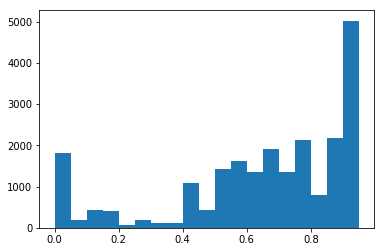

In [47]:
# What are the values of these distances?
plt.hist(dist1.flat, bins=np.arange(0, 1, .05));

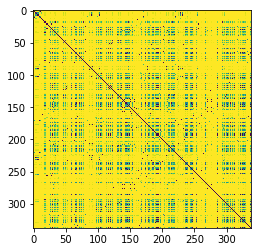

In [14]:
plt.imshow(dist1)

In [15]:
import scipy.cluster

In [16]:
cl2 = scipy.cluster.hierarchy.linkage(scipy.spatial.distance.squareform(dist1), method='single')

In [17]:
cl2.shape

(337, 4)

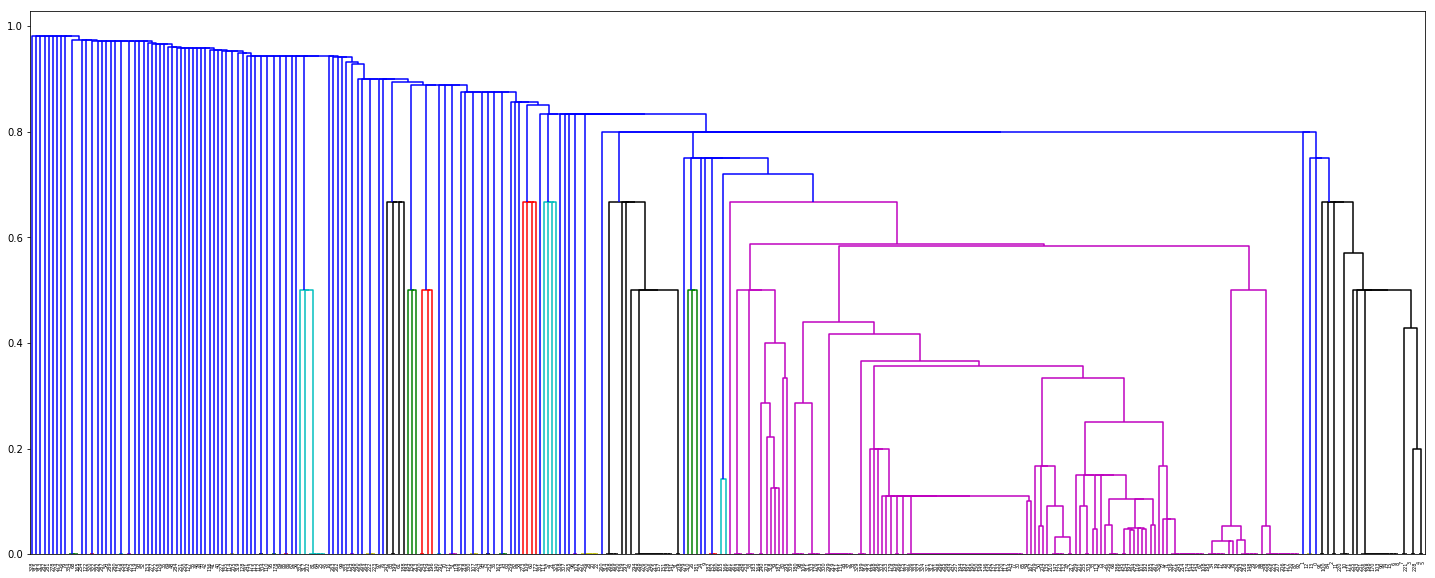

In [18]:
# Plot the hierarchy dendogram
fig = plt.figure(figsize=(25, 10))
scipy.cluster.hierarchy.dendrogram(cl2);

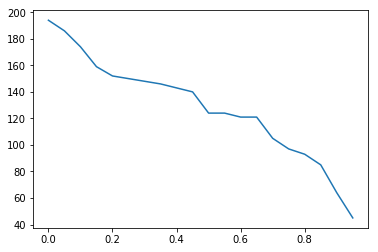

In [19]:
# How many clusters do we have for different distance cut-off values
t_range = np.arange(0, 1, 0.05)
nr_clusters = [len(set(scipy.cluster.hierarchy.fcluster(cl2, t, criterion='distance'))) for t in t_range]
plt.plot(t_range, nr_clusters);

In [21]:
# Create the clustering for different cutoff values
clusters_df = pd.DataFrame()
for t in np.arange(0.1, 1, 0.1):
    clusters = scipy.cluster.hierarchy.fcluster(cl2, t, criterion='distance')
    clusters_s = pd.Series({paths_nonzero_df.index[i]: int(clusters[i]) for i in range(len(clusters))})
    clusters_df['cluster_{:.1f}'.format(t)] = clusters_s

In [22]:
# How large are the largest clusters?
for t in np.arange(0.1, 1, 0.1):
    print(clusters_df['cluster_{:.1f}'.format(t)].value_counts().head(5))

65    29
86    13
84    11
87    10
40    10
Name: cluster_0.1, dtype: int64
61    40
63    20
65    13
64    12
40    10
Name: cluster_0.2, dtype: int64
58    40
60    32
61    13
71    10
62    10
Name: cluster_0.3, dtype: int64
55    85
56    13
66    10
40    10
57    10
Name: cluster_0.4, dtype: int64
41    101
42     23
51     18
40     14
34     13
Name: cluster_0.5, dtype: int64
40    138
48     21
34     13
9       7
32      5
Name: cluster_0.6, dtype: int64
28    139
33     26
24     19
9       7
23      5
Name: cluster_0.7, dtype: int64
24    200
9       7
23      5
12      5
21      4
Name: cluster_0.8, dtype: int64
11    259
9       7
1       3
6       2
8       2
Name: cluster_0.9, dtype: int64


## Save clustering

In [23]:
for t in np.arange(0.1, 1, 0.1):
    att = 'cluster_{:.1f}'.format(t)
    c = clusters_df[att.format(t)].to_dict()
    nx.set_node_attributes(graph, {n: int(c[n]) for n in c}, name=att)

In [24]:
fp_out = '/media/sf_VBox_Shared/CaseLaw/2018-01-29-lido/derived/subnetwork/article/no_phr/communities/'

for t in np.arange(0.2, 1, 0.2):
    nw_t = {'title': nw['title']+' threshold {:.1f}'.format(t),
           'edges': nw['edges'],
           'nodes': [n.copy() for n in nw['nodes']] }
    for n in nw_t['nodes']:
        n['community'] = str(clusters_df.loc[n['id'],'cluster_{:.1f}'.format(t)])
    with open(os.path.join(fp_out, 'network_citdis_{:.1f}.json'.format(t)), 'w') as f:
        json.dump(nw_t, f, indent=True)

In [25]:
arts = nx.get_node_attributes(graph, 'articles')
nx.set_node_attributes(graph, {k: ' '.join(arts[k]) for k in arts}, 'articles')

In [26]:
#nx.readwrite.gexf.write_gexf(graph, '/media/sf_VBox_Shared/CaseLaw/2018-01-29-lido/derived/subnetwork/network-clusters.gexf')
nx.readwrite.gexf.write_gexf(graph, os.path.join(fp_out, 'network_citdis.gexf'))